In [1]:
import pandas as pd
import yfinance as yf
import re
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import time
from math import log, sqrt, pi, exp
from scipy.stats import norm
import math
from matplotlib import pyplot as plt

In [2]:
def initializeUnderlyingDataAndDicts():
    global underlyingData, underlyingPriceDict, underlying15DVolDict, underlying30DVolDict, underlying60DVolDict, underlyingYZVolDict

    # Opening underlying file
    underlyingData = pd.read_csv("data/AAPL.csv")
    
    # Prepare all the underlying volatility dicts
    underlyingData["PriceChange"] = underlyingData["Close"] - underlyingData["Close"].shift(-1)
    underlyingData["PercentChange"] = underlyingData["PriceChange"] / (underlyingData["Close"] + underlyingData["PriceChange"])
    underlyingData['15DayVol'] = underlyingData["PercentChange"].rolling(15).std() * (252 ** 0.5)
    underlyingData['30DayVol'] = underlyingData["PercentChange"].rolling(30).std() * (252 ** 0.5)
    underlyingData['60DayVol'] = underlyingData["PercentChange"].rolling(60).std() * (252 ** 0.5)
    
    # Code from here: https://harbourfronts.com/garman-klass-yang-zhang-historical-volatility-calculation-volatility-analysis-python/
    underlyingData['YZVol'] = np.sqrt(252 / 30 * pd.DataFrame.rolling(np.log(underlyingData.loc[:, "Open"] / underlyingData.loc[:, "Close"].shift(1)) ** 2 +
                         0.5 * np.log(underlyingData.loc[:, "High"] / underlyingData.loc[:, "Low"]) ** 2 -
                         (2 * np.log(2) - 1) *
                         np.log(underlyingData.loc[:, "Close"] / underlyingData.loc[:, "Open"]) ** 2,
                         window=30).sum())
    
    # Remove NaN
    underlyingData = underlyingData.dropna()
    underlyingData.reset_index(drop=True)
    
    # Populate global dictionaries
    underlyingPriceDict = dict(zip(underlyingData.Date, underlyingData.Close))
    underlying15DVolDict = dict(zip(underlyingData.Date, underlyingData["15DayVol"]))
    underlying30DVolDict = dict(zip(underlyingData.Date, underlyingData["30DayVol"]))
    underlying60DVolDict = dict(zip(underlyingData.Date, underlyingData["60DayVol"]))
    underlyingYZVolDict = dict(zip(underlyingData.Date, underlyingData.YZVol))



def getObjectiveClosePrice(underlyingData, date):
    # Gets the close price on a date given objective data. None if date DNE
    # Consider using a hash map.
    try:
        return float(underlyingData.loc[underlyingData['Date'] == date]['Close'])
    except:
        return None

def getOptionProfit(expireDate, strike):
    # Gets the profit of an option given its expiration date and strike price
    endPrice = underlyingPriceDict[expireDate]
    if endPrice == None:
        return 0
    return max(endPrice - strike, 0)    
    
def getAndProcessOneYearOptionData():
    initializeUnderlyingDataAndDicts()
    finalDay = '2022-04-27'
    
    # Creating masterDf 
    masterDf = pd.read_csv("data/aapl_eod_202101.txt")
    for i in range(2, 13):
        masterDf = masterDf.append(pd.read_csv("data/aapl_eod_2021" + str(i).zfill(2) + ".txt"))
    
    # Dropping irrelevant columns
    cols_to_drop = [0, 1, 3, 6, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
    masterDf.drop(masterDf.columns[cols_to_drop],axis=1,inplace=True)
    
    # Modifying column names for readability
    col_names = []
    for x in list(masterDf.columns):
        x = x.replace(' [', '').replace(']', '')
        col_names.append(x)

    masterDf.columns = col_names

    # Converting all but a few columns to numeric and removing NaN
    for i in range(len(col_names)):
        if i == 0 or i == 2 or i == 11:
            continue
        masterDf[col_names[i]] = pd.to_numeric(masterDf[col_names[i]], errors='coerce')
        masterDf = masterDf[masterDf[col_names[i]].notna()]
    
    # Stripping strings in problematic columns
    masterDf['QUOTE_DATE'] = masterDf['QUOTE_DATE'].str.strip()
    masterDf['C_SIZE'] = masterDf['C_SIZE'].str.strip()
    masterDf['EXPIRE_DATE'] = masterDf['EXPIRE_DATE'].str.strip()

    # Risk free rate column
    riskFreeRateDf = pd.read_csv("data/RiskFreeRate.csv")
    riskFreeRateDict = dict(zip(riskFreeRateDf.DATE, riskFreeRateDf.DTB3))
    masterDf['RISK_FREE_RATE'] = masterDf['QUOTE_DATE'].map(riskFreeRateDict)
    masterDf['RISK_FREE_RATE'] = pd.to_numeric(masterDf['RISK_FREE_RATE'], errors='coerce')
    masterDf = masterDf[masterDf['RISK_FREE_RATE'].notna()]
    
    # Map volatility columns
    masterDf["15DayVol"] = masterDf["QUOTE_DATE"].map(underlying15DVolDict)
    masterDf["30DayVol"] = masterDf["QUOTE_DATE"].map(underlying30DVolDict)
    masterDf["60DayVol"] = masterDf["QUOTE_DATE"].map(underlying60DVolDict)
    masterDf["YZVol"] = masterDf["QUOTE_DATE"].map(underlyingYZVolDict)
    
    # Converting date columns to dates. Requires .date() to become DateTime
    masterDf['EXPIRE_DATE'] = pd.to_datetime(masterDf['EXPIRE_DATE'])
    masterDf['QUOTE_DATE'] = pd.to_datetime(masterDf['QUOTE_DATE'])
    
    # Remove all options past the last date of underlying data
    masterDf = masterDf[~(masterDf['EXPIRE_DATE'] > finalDay)]
    
    # Map option profits
    masterDf['OPTION_PROFIT'] = masterDf.apply(lambda x: getOptionProfit(str(x['EXPIRE_DATE'].date()), x['STRIKE']), axis=1)
    masterDf['BID_ASK_MIDPOINT'] = masterDf.apply(lambda x: (x['C_ASK'] + x['C_BID']) / 2, axis=1)
    return masterDf

def filter_for_moneyness_and_time(df, low_money = None, high_money = None, low_time = None, high_time = None):
    if low_money == None and high_money == None:
        pass
    elif low_money == None:
        df = df[df['STRIKE'] / df['UNDERLYING_LAST'] <= high_money]
    elif high_money == None:
        df = df[df['STRIKE'] / df['UNDERLYING_LAST'] >= low_money]
    else:
        df = df[(df['STRIKE'] / df['UNDERLYING_LAST'] >= low_money) & (df['STRIKE'] / df['UNDERLYING_LAST'] <= high_money)]

    if low_time == None and high_time == None:
        return df
    if low_time == None:
        return df[df['DTE'] <= high_time]
    elif high_time == None:
        return df[df['DTE'] >= low_time]
    else:
        return df[(df['DTE'] >= low_time) & (df['DTE'] <= high_time)]     

In [3]:
low_money_vals = [0.2, 0.8, 1.2]
high_money_vals = [0.8, 1.2, 1.8]
low_time_vals = [0.001, 30, 90]
high_time_vals = [30, 90, 300]
volTypes = ['15DayVol', '30DayVol', '60DayVol', 'YZVol']

In [4]:
df = getAndProcessOneYearOptionData()
df

C:\Users\David\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,...,STRIKE,STRIKE_DISTANCE,STRIKE_DISTANCE_PCT,RISK_FREE_RATE,15DayVol,30DayVol,60DayVol,YZVol,OPTION_PROFIT,BID_ASK_MIDPOINT
13,2021-01-04,129.45,2021-01-08,4.00,0.99330,0.00182,0.00267,-0.01615,0.01475,0.70653,...,106.0,23.4,0.181,0.09,0.335185,0.290138,0.345166,0.282196,26.050003,23.475
16,2021-01-04,129.45,2021-01-08,4.00,0.99171,0.00236,0.00355,-0.01585,0.01479,0.61801,...,109.0,20.4,0.158,0.09,0.335185,0.290138,0.345166,0.282196,23.050003,20.475
17,2021-01-04,129.45,2021-01-08,4.00,0.99211,0.00254,0.00301,-0.01615,0.01530,0.58957,...,110.0,19.4,0.150,0.09,0.335185,0.290138,0.345166,0.282196,22.050003,19.480
18,2021-01-04,129.45,2021-01-08,4.00,0.98019,0.00493,0.00688,-0.04014,0.01468,0.65222,...,111.0,18.4,0.143,0.09,0.335185,0.290138,0.345166,0.282196,21.050003,18.520
19,2021-01-04,129.45,2021-01-08,4.00,0.98415,0.00440,0.00543,-0.02860,0.01464,0.58313,...,112.0,17.4,0.135,0.09,0.335185,0.290138,0.345166,0.282196,20.050003,17.495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19210,2021-12-31,177.58,2022-04-14,103.96,0.06265,0.00433,0.11726,-0.01649,0.02991,0.29953,...,230.0,52.4,0.295,0.06,0.293058,0.297586,0.243602,0.311005,0.000000,0.730
19211,2021-12-31,177.58,2022-04-14,103.96,0.05137,0.00364,0.10102,-0.01461,0.02492,0.30623,...,235.0,57.4,0.323,0.06,0.293058,0.297586,0.243602,0.311005,0.000000,0.595
19212,2021-12-31,177.58,2022-04-14,103.96,0.04452,0.00317,0.08905,-0.01318,0.02085,0.31495,...,240.0,62.4,0.351,0.06,0.293058,0.297586,0.243602,0.311005,0.000000,0.515
19213,2021-12-31,177.58,2022-04-14,103.96,0.03869,0.00268,0.08006,-0.01283,0.01835,0.32534,...,245.0,67.4,0.380,0.06,0.293058,0.297586,0.243602,0.311005,0.000000,0.455


In [5]:
def MLP_rmse(low_money, high_money, low_time, high_time, df):
    #start = time.time()
    df = filter_for_moneyness_and_time(df, low_money, high_money, low_time, high_time)
    X = df.iloc[:, [1, 3, 14, 17, 18, 19, 20, 21]].values
    y = df.iloc[:, -1].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
    
    sc = MinMaxScaler()
    X_train_sc = pd.DataFrame(sc.fit_transform(X_train))
    X_test_sc = pd.DataFrame(sc.transform(X_test))
    
    model = MLPRegressor(activation = 'relu', max_iter = 1000, tol = 0.0001)
    model.fit(X_train_sc, y_train)
    
    y_train_pred = model.predict(X_train_sc)
    y_test_pred = model.predict(X_test_sc)
    print("MLP RMSE on test data for moneyness(" + str(low_money) + ", " + str(high_money) + ") and DTE(" + str(low_time) + ", " + 
          str(high_time) + "): " + str(metrics.mean_squared_error(y_test, y_test_pred) ** 0.5))
    # print("Run in: " + str(time.time() - start) + " sec")
    # return model

In [10]:
for i in range(len(low_money_vals)):
    low_money = low_money_vals[i]
    high_money = high_money_vals[i]
    for j in range(len(low_time_vals)):
        low_time = low_time_vals[j]
        high_time = high_time_vals[j]
        MLP_rmse(low_money, high_money, low_time, high_time, df)

MLP RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.17054383397379533
MLP RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.21420461699399332
MLP RMSE on test data for moneyness(0.2, 0.8) and DTE(90, 300): 0.43434401137151823
MLP RMSE on test data for moneyness(0.8, 1.2) and DTE(0.001, 30): 0.26122819110096057
MLP RMSE on test data for moneyness(0.8, 1.2) and DTE(30, 90): 0.2757475562460674
MLP RMSE on test data for moneyness(0.8, 1.2) and DTE(90, 300): 0.6101565138990177
MLP RMSE on test data for moneyness(1.2, 1.8) and DTE(0.001, 30): 0.05256954083949938
MLP RMSE on test data for moneyness(1.2, 1.8) and DTE(30, 90): 0.10943739765789968
MLP RMSE on test data for moneyness(1.2, 1.8) and DTE(90, 300): 0.15556650777921743


In [11]:
# Code from https://medium.com/swlh/calculating-option-premiums-using-the-black-scholes-model-in-python-e9ed227afbee
def d1(S,K,T,r,sigma):
    return(log(S/K)+(r-0.0063+sigma**2/2.)*T)/(sigma*sqrt(T))
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma*sqrt(T)
def blackScholes(S,K,T,r,sigma):
    return S*norm.cdf(d1(S,K,T,r,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,sigma))

In [12]:
def BS_rmse(low_money, high_money, low_time, high_time, df, volType):
    df = filter_for_moneyness_and_time(df, low_money, high_money, low_time, high_time)
    n = 0
    squared_error = 0
    for index, row in df.iterrows():
        n += 1
        squared_error += (row['BID_ASK_MIDPOINT'] - blackScholes(row['UNDERLYING_LAST'], row['STRIKE'], row['DTE'] / 252, row['RISK_FREE_RATE'], row[volType])) ** 2
        
    print("BS(" + volType + ") RMSE on test data for moneyness(" + str(low_money) + ", " + str(high_money) + ") and DTE(" + str(low_time) + ", " + 
          str(high_time) + "): " + str((squared_error / n) ** 0.5))

In [13]:
for i in range(len(low_money_vals)):
    low_money = low_money_vals[i]
    high_money = high_money_vals[i]
    for j in range(len(low_time_vals)):
        low_time = low_time_vals[j]
        high_time = high_time_vals[j]
        for k in range(len(volTypes)):
            volType = volTypes[k]
            BS_rmse(low_money, high_money, low_time, high_time, df, volType)

BS(15DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.2840622076110615
BS(30DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.28240349416847255
BS(60DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.28208485922390786
BS(YZVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.28244378840519296
BS(15DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.7992849444812222
BS(30DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.7848795290316628
BS(60DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.7815748449069472
BS(YZVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.7881297578958645
BS(15DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(90, 300): 1.878188121141681
BS(30DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(90, 300): 1.8511641596001136
BS(60DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(90, 300): 1.86817

In [14]:
def monteCarloPaths(S, T, r, q, sigma, steps, N):
    dt = T/steps
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt + sigma*np.sqrt(dt) * np.random.normal(size=(steps,N))),axis=0)
    return np.exp(ST)

def optionPriceMonteCarlo(S, K, T, r, q, sigma, steps, N):
    paths= monteCarloPaths(S,T,r, q,sigma,steps,N)
    payoffs = np.maximum(paths[-1]-K, 0)
    option_price = np.exp(-r*T)*np.mean(payoffs)
    return option_price

In [15]:
def monteCarlo_rmse(low_money, high_money, low_time, high_time, df, volType):
    df = filter_for_moneyness_and_time(df, low_money, high_money, low_time, high_time)
    n = 0
    squared_error = 0
    for index, row in df.iterrows():
        n += 1
        #optionPriceMonteCarlo(row['UNDERLYING_LAST'], row['STRIKE'], row['DTE'] / 252, row['RISK_FREE_RATE'], 0.0063, row[volType], row['DTE'], 100)
        squared_error += (row['BID_ASK_MIDPOINT'] - optionPriceMonteCarlo(row['UNDERLYING_LAST'], row['STRIKE'], row['DTE'] / 252, row['RISK_FREE_RATE'], 0.0063, row[volType], math.ceil(row['DTE']), 2000)) ** 2
        
    print("Monte Carlo(" + volType + ") RMSE on test data for moneyness(" + str(low_money) + ", " + str(high_money) + ") and DTE(" + str(low_time) + ", " + 
          str(high_time) + "): " + str((squared_error / n) ** 0.5))
    

In [16]:
for i in range(len(low_money_vals)):
    low_money = low_money_vals[i]
    high_money = high_money_vals[i]
    for j in range(len(low_time_vals)):
        low_time = low_time_vals[j]
        high_time = high_time_vals[j]
        for k in range(len(volTypes)):
            volType = volTypes[k]
            monteCarlo_rmse(low_money, high_money, low_time, high_time, df, volType)

Monte Carlo(15DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.32046890087866514
Monte Carlo(30DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.3185885902512821
Monte Carlo(60DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.3168910484485944
Monte Carlo(YZVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(0.001, 30): 0.3236065142993624
Monte Carlo(15DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.7416310021534565
Monte Carlo(30DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.730447789283935
Monte Carlo(60DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.7229839268708765
Monte Carlo(YZVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(30, 90): 0.737857929977143
Monte Carlo(15DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(90, 300): 1.5723387637880908
Monte Carlo(30DayVol) RMSE on test data for moneyness(0.2, 0.8) and DTE(90, 300): 1.5358143484

In [91]:
# Sample option:
#2021-01-07	130.86	2021-02-26	50.0	0.38273	0.02019	0.18634	-0.07054	0.06201	0.38545	...	138.0	7.1	0.055	0.09	0.331410	0.303940	0.326342	0.304212	0.0	4.650
x_vals = []
bs_vals = []
bs_price = blackScholes(130.86, 138, 50/252, 0.09, 0.304212)

for i in range(4, 61):
    x_vals.append(math.ceil(10 ** (i/10)))
    bs_vals.append(bs_price)

mc_vals = []
for x in x_vals:
    print(x)
    mc_vals.append(optionPriceMonteCarlo(130.86, 138, 50/252, 0.09, 0.0063, 0.304212, 50, x))

3
4
4
6
7
8
10
13
16
20
26
32
40
51
64
80
100
126
159
200
252
317
399
502
631
795
1000
1259
1585
1996
2512
3163
3982
5012
6310
7944
10000
12590
15849
19953
25119
31623
39811
50119
63096
79433
100000
125893
158490
199527
251189
316228
398108
501188
630958
794329
1000000


In [87]:
x_vals

[2,
 4,
 6,
 10,
 18,
 32,
 57,
 100,
 178,
 317,
 563,
 1000,
 1779,
 3163,
 5624,
 10000,
 17783,
 31623,
 56235,
 100000,
 177828,
 316228,
 562342,
 1000000]

In [88]:
bs_vals

[5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443,
 5.088544932410443]

In [93]:
mc_vals

[0.0,
 5.4828248317391575,
 5.286119414901078,
 0.1715383605005094,
 2.320535921544255,
 13.070572484123929,
 0.38083236147885335,
 9.790539790519128,
 7.366837121034695,
 6.437455720813425,
 5.873600802771084,
 7.739207800498948,
 6.155343776024108,
 4.275341407279509,
 9.316356777988032,
 4.678881487616164,
 3.920258736104242,
 5.074214786557684,
 5.173779189147623,
 4.2282494333191645,
 4.6574376933560515,
 5.533003141137154,
 5.100553611249373,
 4.634926877994141,
 4.513373946843022,
 5.165340947656521,
 5.281647267954719,
 4.941760812806552,
 4.825262700278313,
 4.7421487134904465,
 4.860125666807073,
 4.835156967225406,
 5.031822753318916,
 4.8230372560425945,
 5.243641530668503,
 4.866842731563788,
 4.979749133663267,
 5.172837784743533,
 4.970707901982641,
 4.988947040471722,
 5.068298749244681,
 5.015870788825821,
 5.081574842773508,
 5.0790650291627415,
 5.036071735692315,
 4.966235722215241,
 5.072827781723999,
 5.037118761796343,
 5.000643983912971,
 5.009317643992868,
 5.0

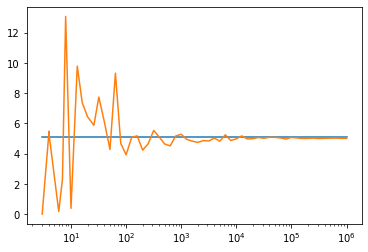

In [92]:
plt.xscale('log')
plt.plot(x_vals, bs_vals, x_vals, mc_vals)

In [100]:
paths = monteCarloPaths(130.86, 50/252, 0.09, 0.0063, 0.304212, 50, 10000000)

path[-1][0:5]

KeyboardInterrupt: 

3
4
4
6
7
8
10
13
16
20
26
32
40
51
64
80
100
126
159
200
252
317
399
502
631
795
1000
1259
1585
1996
2512
3163
3982
5012
6310
7944
10000
12590
15849
19953
25119
31623
39811
50119
63096
79433
100000
125893
158490
199527
251189
316228
398108
501188
630958
794329
1000000
1258926
1584894
1995263
2511887
3162278
3981072
5011873
6309574
7943283
10000000


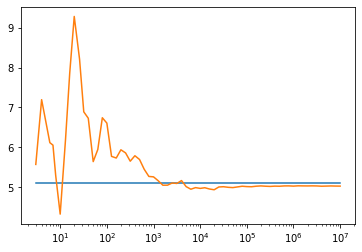

In [103]:
def incrimental_MonteCarlo(S, K, T, r, q, sigma, steps, N):
    # Black Scholes
    x_vals = []
    bs_vals = []
    bs_price = blackScholes(130.86, 138, 50/252, 0.09, 0.304212)
    for i in range(4, 71):
        x_vals.append(math.ceil(10 ** (i/10)))
        bs_vals.append(bs_price)
    
    # Monte Carlo
    paths = monteCarloPaths(S,T,r, q,sigma,steps,N)
    
    mc_vals = []
    for x in x_vals:
        print(x)
        payoffs = np.maximum(paths[-1][:x]-K, 0)
        mc_vals.append(np.exp(-r*T)*np.mean(payoffs))
    plt.xscale('log')
    plt.plot(x_vals, bs_vals, x_vals, mc_vals)

# Sample option:
#2021-01-07	130.86	2021-02-26	50.0	0.38273	0.02019	0.18634	-0.07054	0.06201	0.38545	...	138.0	7.1	0.055	0.09	0.331410	0.303940	0.326342	0.304212	0.0	4.650


incrimental_MonteCarlo(130.86, 138, 50/252, 0.09, 0.0063, 0.304212, 50, 10000000)